In [2]:
######## snakemake preamble start (automatically inserted, do not edit) ########
library(methods)
Snakemake <- setClass(
    "Snakemake",
    slots = c(
        input = "list",
        output = "list",
        params = "list",
        wildcards = "list",
        threads = "numeric",
        log = "list",
        resources = "list",
        config = "list",
        rule = "character",
        bench_iteration = "numeric",
        scriptdir = "character",
        source = "function"
    )
)
snakemake <- Snakemake(
    input = list('rds' = 'out/ipynb/compute_differential_methylation/all_unpaired.rds'),
    output = list('xlsx' = 'out/ipynb/visualize_heatmap_by_gene/CUX2.xlsx'),
    params = list(),
    wildcards = list('dev_unpaired', "design" = 'dev_unpaired'),
    threads = 2,
    # log = list('out/ipynb/compute_differential_methylation/dev_unpaired.rds', 'out/ipynb/compute_differential_methylation/dev_unpaired.r.ipynb', "rds" = 'out/ipynb/compute_differential_methylation/dev_unpaired.rds', "notebook" = 'out/ipynb/compute_differential_methylation/dev_unpaired.r.ipynb'),
    resources = list('tmpdir', "tmpdir" = '/tmp'),
    config = list(),
    rule = 'ipynb_compute_differential_methylation',
    bench_iteration = as.numeric(NA),
    scriptdir = '/mnt/thymus/synoSalva/illumina_sequencing_data/mw/mw-oncodiag/src/snakemake/rules/../../ipynb',
    source = function(...){
        wd <- getwd()
        setwd(snakemake@scriptdir)
        source(...)
        setwd(wd)
    }
)
setwd('/mnt/thymus/synoSalva/illumina_sequencing_data/mw/mw-oncodiag/');

######## snakemake preamble end #########


In [3]:
# start coding here

In [4]:
IRdisplay::display_markdown(
    sprintf(
"_Visualize heatmap all CG by gene_

__Oncodiag project__

[Guillaume Charbonnier](mailto:gc.bioinfo@gmail.com)

%s",
        format(Sys.Date(), "%Y-%m-%d")
    )
)

_Visualize heatmap all CG by gene_

__Oncodiag project__

[Guillaume Charbonnier](mailto:gc.bioinfo@gmail.com)

2023-03-25

# Abstract

The aim of this analysis is to produce heatmaps for all differentially methylated CG for the key genes of interest: SLC23A2, ANXA3 and CUX2.

# Methods

## Load dependencies

### Packages

In [46]:
if (!require("BiocManager", quietly = TRUE)) {
    install.packages(
        "BiocManager",
        quiet = TRUE
    )
}
packages <- c(
  "data.table",
  "dplyr",
  "openxlsx",
  "DT",
  # "methylSig",
  "DSS",
  "bsseq",
  "ChIPpeakAnno",
  # "ChIPseeker",
  # "methyAnalysis",
  "org.Hs.eg.db",
  "TxDb.Hsapiens.UCSC.hg19.knownGene",
  # "EnhancedVolcano",
  # "data.table",
  "ggpubr",
  "ComplexHeatmap",
  "tidyr"
)
BiocManager::install(
    packages,
    update = FALSE,
    quiet = TRUE,
    Ncpus = parallel::detectCores()
)
invisible(
    lapply(
      packages,
      library,
      character.only = TRUE
    )
)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.16 (BiocManager 1.30.19), R 4.2.2 (2022-10-31)

Warning message:
"package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'data.table' 'dplyr' 'openxlsx' 'DT' 'DSS'
  'bsseq' 'ChIPpeakAnno' 'org.Hs.eg.db' 'TxDb.Hsapiens.UCSC.hg19.knownGene'
  'ggpubr' 'ComplexHeatmap' 'tidyr'"

Attaching package: 'data.table'


The following object is masked from 'package:SummarizedExperiment':

    shift


The following object is masked from 'package:GenomicRanges':

    shift


The following object is masked from 'package:IRanges':

    shift


The following objects are masked from 'package:S4Vectors':

    first, second


The following objects are masked from 'package:dplyr':

    between, first, last




In [6]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS/LAPACK: /cobelix/spicuglia/mambaforge/envs/rkernel_diff_meth/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] tidyr_1.3.0                            
 [2] ComplexHeatmap_2.14.0                  
 [3] ggpubr_0.6.0                           
 [4] ggplot2_3.4.1                          
 [5] TxDb.Hsapiens.UCSC.hg19.knownGene_3.2.2
 [6] GenomicFeatures_1.50.2                 
 [7] org.Hs.eg.db_3.16.0               

In [7]:
set_plot_dim <- function(
    width = 16,
    height = 9
) {
    options(
        #jupyter.plot_scale=1,
        repr.plot.width = width,
        repr.plot.height = height
    )
}
set_plot_dim()

### Data

In [8]:
# dml_res <- readRDS(snakemake@input$rds)
dml_res <- readRDS("out/ipynb/compute_differential_methylation/all_unpaired.rds")
dim(dml_res)

[1] 55329507       11

In [9]:
dml_signif_res = callDML(
    dml_res,
    delta = 0.2,
    p.threshold = 0.001
)
dim(dml_signif_res)

[1] 1144667      12

In [10]:
# We need to move to the assay directory, else subsetting will not work
setwd("out/ipynb/compute_differential_methylation/all_unpairedhdf5a/")

In [11]:
se <- readRDS("se.rds")
se

An object of type 'BSseq' with
  55628636 methylation loci
  30 samples
has not been smoothed
Some assays are HDF5Array-backed

## Subset for each gene of interest

In [14]:
flanking_region <- 10000
# Subset by gene coordinates
se_CUX2 <- subsetByOverlaps(
    se,
    GRanges(
        seqnames = "12",
        ranges = IRanges(
            start = 111471828 - flanking_region,  # 140
            end = 111788358 + flanking_region # 150
        )
    )
)
se_CUX2

An object of type 'BSseq' with
  10360 methylation loci
  30 samples
has not been smoothed
Some assays are HDF5Array-backed

In [15]:
se_ANXA3 <- subsetByOverlaps(
    se,
    GRanges(
        seqnames = "4",
        ranges = IRanges(
            start = 79472673 - flanking_region,  # 150
            end = 79531597 + flanking_region # 160
        )
    )
)
se_ANXA3

An object of type 'BSseq' with
  1360 methylation loci
  30 samples
has not been smoothed
Some assays are HDF5Array-backed

In [17]:
se_SLC22A3 <- subsetByOverlaps(
    se,
    GRanges(
        seqnames = "6",
        ranges = IRanges(
            start = 160769300 - flanking_region,  # 140
            end = 160876014 + flanking_region # 150
        )
    )
)
se_SLC22A3

An object of type 'BSseq' with
  2462 methylation loci
  30 samples
has not been smoothed
Some assays are HDF5Array-backed

## Annotate differential loci

In [ ]:
# # txdb <- TxDb.Hsapiens.UCSC.hg19.knownGene
# peakAnno <- annotatePeak(
#     dml_res[1:4,], 
#     tssRegion = c(-3000, 3000),
#     TxDb = TxDb.Hsapiens.UCSC.hg19.knownGene,
#     annoDb = "org.Hs.eg.db"
# )
# peakAnno

In [18]:
TxDb.Hsapiens.UCSC.hg19.knownGene

TxDb object:
# Db type: TxDb
# Supporting package: GenomicFeatures
# Data source: UCSC
# Genome: hg19
# Organism: Homo sapiens
# Taxonomy ID: 9606
# UCSC Table: knownGene
# Resource URL: http://genome.ucsc.edu/
# Type of Gene ID: Entrez Gene ID
# Full dataset: yes
# miRBase build ID: GRCh37
# transcript_nrow: 82960
# exon_nrow: 289969
# cds_nrow: 237533
# Db created by: GenomicFeatures package from Bioconductor
# Creation time: 2015-10-07 18:11:28 +0000 (Wed, 07 Oct 2015)
# GenomicFeatures version at creation time: 1.21.30
# RSQLite version at creation time: 1.0.0
# DBSCHEMAVERSION: 1.1

In [19]:
# Annotate DMR
annoData <- toGRanges(
    TxDb.Hsapiens.UCSC.hg19.knownGene,
    feature = "gene"
)
annoData

  403 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.



GRanges object with 23056 ranges and 0 metadata columns:
        seqnames              ranges strand
           <Rle>           <IRanges>  <Rle>
      1    chr19   58858172-58874214      -
     10     chr8   18248755-18258723      +
    100    chr20   43248163-43280376      -
   1000    chr18   25530930-25757445      -
  10000     chr1 243651535-244006886      -
    ...      ...                 ...    ...
   9991     chr9 114979995-115095944      -
   9992    chr21   35736323-35743440      +
   9993    chr22   19023795-19109967      -
   9994     chr6   90539619-90584155      +
   9997    chr22   50961997-50964905      -
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

In [21]:
gr_CUX2 <- suppressWarnings(
    annotatePeakInBatch(
        granges(se_CUX2),
        AnnotationData = annoData
    )
)
gr_CUX2 <- addGeneIDs(
    gr_CUX2,
    orgAnn="org.Hs.eg.db",
    feature_id_type = "entrez_id",
    IDs2Add=c("symbol")
)
gr_CUX2

GRanges object with 10360 ranges and 10 metadata columns:
                seqnames    ranges strand |        peak     feature
                   <Rle> <IRanges>  <Rle> | <character> <character>
   X00001.23316       12 111461830      * |       00001       23316
   X00002.23316       12 111461831      * |       00002       23316
   X00003.23316       12 111461893      * |       00003       23316
   X00004.23316       12 111461894      * |       00004       23316
   X00005.23316       12 111461920      * |       00005       23316
            ...      ...       ...    ... .         ...         ...
  X10356.144717       12 111798225      * |       10356      144717
  X10357.144717       12 111798323      * |       10357      144717
  X10358.144717       12 111798324      * |       10358      144717
  X10359.144717       12 111798354      * |       10359      144717
  X10360.144717       12 111798355      * |       10360      144717
                start_position end_position feature_strand

In [23]:
gr_ANXA3 <- suppressWarnings(
    annotatePeakInBatch(
        granges(se_ANXA3),
        AnnotationData = annoData
    )
)
gr_ANXA3 <- addGeneIDs(
    gr_ANXA3,
    orgAnn="org.Hs.eg.db",
    feature_id_type = "entrez_id",
    IDs2Add=c("symbol")
)
gr_ANXA3

GRanges object with 1360 ranges and 10 metadata columns:
                  seqnames    ranges strand |        peak     feature
                     <Rle> <IRanges>  <Rle> | <character> <character>
        X0001.306        4  79462766      * |        0001         306
        X0002.306        4  79462767      * |        0002         306
        X0003.306        4  79462806      * |        0003         306
        X0004.306        4  79462807      * |        0004         306
        X0005.306        4  79462900      * |        0005         306
              ...      ...       ...    ... .         ...         ...
  X1356.100505702        4  79541416      * |        1356   100505702
  X1357.100505702        4  79541474      * |        1357   100505702
  X1358.100505702        4  79541475      * |        1358   100505702
  X1359.100505702        4  79541486      * |        1359   100505702
  X1360.100505702        4  79541487      * |        1360   100505702
                  start_position 

In [25]:
gr_SLC22A3 <- suppressWarnings(
    annotatePeakInBatch(
        granges(se_SLC22A3),
        AnnotationData = annoData
    )
)
gr_SLC22A3 <- addGeneIDs(
    gr_SLC22A3,
    orgAnn="org.Hs.eg.db",
    feature_id_type = "entrez_id",
    IDs2Add=c("symbol")
)
gr_SLC22A3

GRanges object with 2462 ranges and 10 metadata columns:
              seqnames    ranges strand |        peak     feature
                 <Rle> <IRanges>  <Rle> | <character> <character>
   X0001.6581        6 160759312      * |        0001        6581
   X0002.6581        6 160759313      * |        0002        6581
   X0003.6581        6 160759531      * |        0003        6581
   X0004.6581        6 160759532      * |        0004        6581
   X0005.6581        6 160759550      * |        0005        6581
          ...      ...       ...    ... .         ...         ...
  X2458.80350        6 160885775      * |        2458       80350
  X2459.80350        6 160885778      * |        2459       80350
  X2460.80350        6 160885779      * |        2460       80350
  X2461.80350        6 160885951      * |        2461       80350
  X2462.80350        6 160885952      * |        2462       80350
              start_position end_position feature_strand insideFeature
              

In [27]:
# There is no need to deduplicate peaks, as they are already unique
table(duplicated(gr_CUX2$peak))
table(duplicated(gr_ANXA3$peak))
table(duplicated(gr_SLC22A3$peak))


FALSE 
10360 


FALSE 
 1360 


FALSE 
 2462 

In [48]:
B_CUX2 <- data.table(
    coords = paste(
        seqnames(se_CUX2),
        start(se_CUX2),
        sep=":"
    ),
    round(
        as.matrix(
            getCoverage(se_CUX2, type = "M") / getCoverage(se_CUX2, type = "Cov")
        ),
        2
    )
)
B_ANXA3 <- data.table(
    coords = paste(
        seqnames(se_ANXA3),
        start(se_ANXA3),
        sep=":"
    ),
    round(
        as.matrix(
            getCoverage(se_ANXA3, type = "M") / getCoverage(se_ANXA3, type = "Cov")
        ),
        2
    )
)
B_SLC22A3 <- data.table(
    coords = paste(
    seqnames(se_SLC22A3),
    start(se_SLC22A3),
    sep=":"
    ),
    round(
        as.matrix(
            getCoverage(se_SLC22A3, type = "M") / getCoverage(se_SLC22A3, type = "Cov")
        ),
        2
    )
)

In [49]:
B_ANXA3

coords,ODG_080,ODG_081,ODG_082,ODG_083,ODG_084,ODG_085,ODG_086,ODG_087,ODG_088,⋯,ODG_100,ODG_101,ODG_102,ODG_103,ODG_104,ODG_105,ODG_106,ODG_107,ODG_108,ODG_109
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4:79462766,0.80,0.86,0.95,0.57,0.83,0.89,0.85,0.50,0.72,⋯,1.00,0.67,1.00,1.00,1.00,1.00,0.78,0.67,1.00,1.00
4:79462767,0.89,1.00,0.93,0.60,0.94,0.90,0.89,1.00,0.67,⋯,0.82,0.87,0.83,1.00,0.89,0.83,0.89,0.85,0.89,0.88
4:79462806,0.88,1.00,0.88,0.70,0.83,1.00,0.92,1.00,0.88,⋯,0.86,1.00,1.00,1.00,0.92,1.00,0.88,0.91,1.00,1.00
4:79462807,0.78,1.00,0.82,0.94,0.94,1.00,1.00,1.00,0.80,⋯,0.89,1.00,1.00,1.00,0.94,1.00,0.88,1.00,0.78,1.00
4:79462900,0.75,0.75,1.00,1.00,0.81,0.94,0.83,0.83,0.60,⋯,0.80,1.00,0.77,0.91,0.81,1.00,0.83,0.83,0.93,0.75
4:79462901,0.91,1.00,0.78,1.00,0.85,1.00,0.92,1.00,0.83,⋯,0.89,1.00,0.75,1.00,1.00,0.83,0.89,0.86,0.88,1.00
4:79462961,1.00,0.73,0.75,0.67,0.70,0.59,0.46,0.62,0.75,⋯,0.67,0.85,0.81,0.80,0.83,0.67,0.78,0.75,0.70,1.00
4:79462962,0.70,0.79,0.58,0.62,0.56,0.81,0.86,0.50,0.67,⋯,0.80,0.82,0.80,0.75,0.80,0.92,0.71,0.75,0.75,0.67
4:79462985,1.00,0.93,0.92,0.89,1.00,1.00,0.86,0.88,1.00,⋯,0.88,1.00,0.92,0.94,0.88,0.80,1.00,1.00,0.91,1.00


In [61]:
dml_res$coords <- paste(
    dml_res$chr,
    dml_res$pos,
    sep = ":"
)

cols_to_keep <- c(
    'symbol',
    'start_position',
    'end_position',
    'feature_strand',
    'insideFeature',
    'distancetoFeature',
    'chr',
    'pos',
    'mu1',
    'mu2',
    'diff',
    'pval',
    'fdr',
    'ODG_080',
    'ODG_081',
    'ODG_082',
    'ODG_083',
    'ODG_084',
    'ODG_085',
    'ODG_086',
    'ODG_087',
    'ODG_088',
    'ODG_089',
    'ODG_090',
    'ODG_091',
    'ODG_092',
    'ODG_093',
    'ODG_094',
    'ODG_095',
    'ODG_096',
    'ODG_097',
    'ODG_098',
    'ODG_099',
    'ODG_100',
    'ODG_101',
    'ODG_102',
    'ODG_103',
    'ODG_104',
    'ODG_105',
    'ODG_106',
    'ODG_107',
    'ODG_108',
    'ODG_109'
)



In [63]:
dt_CUX2 <- left_join(
    B_CUX2,
    dml_res,
    by = "coords"
)
dt_CUX2 <- cbind(
    as.data.table(mcols(gr_CUX2)),
    dt_CUX2
)
dt_CUX2 <- dt_CUX2[, ..cols_to_keep]
dt_CUX2[, pos := pos + 1]
dt_CUX2

symbol,start_position,end_position,feature_strand,insideFeature,distancetoFeature,chr,pos,mu1,mu2,⋯,ODG_100,ODG_101,ODG_102,ODG_103,ODG_104,ODG_105,ODG_106,ODG_107,ODG_108,ODG_109
<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CUX2,111471828,111788358,+,upstream,-9998,12,111461831,0.59501415,0.59857608,⋯,0.25,0.17,0.50,0.00,0.21,0.50,0.33,0.00,0.33,0.00
CUX2,111471828,111788358,+,upstream,-9997,12,111461832,0.59501415,0.59857608,⋯,0.10,0.18,0.14,0.15,0.14,0.09,0.18,0.25,0.20,0.00
CUX2,111471828,111788358,+,upstream,-9935,12,111461894,0.45663991,0.53412858,⋯,0.40,0.38,0.60,0.10,0.54,0.00,0.11,0.00,0.27,0.50
CUX2,111471828,111788358,+,upstream,-9934,12,111461895,0.45663991,0.53412858,⋯,0.38,0.27,0.80,0.20,0.67,0.31,0.18,0.00,0.26,0.00
CUX2,111471828,111788358,+,upstream,-9908,12,111461921,0.39566938,0.48235539,⋯,0.80,0.89,0.92,0.67,1.00,1.00,1.00,1.00,1.00,0.75
CUX2,111471828,111788358,+,upstream,-9907,12,111461922,0.39566938,0.48235539,⋯,0.75,0.80,0.67,0.55,0.92,0.78,0.82,0.75,0.72,0.88
CUX2,111471828,111788358,+,upstream,-9893,12,111461936,0.39566938,0.48235539,⋯,0.80,1.00,1.00,1.00,0.94,1.00,1.00,0.83,1.00,0.75
CUX2,111471828,111788358,+,upstream,-9892,12,111461937,0.39566938,0.48235539,⋯,0.88,0.94,1.00,0.88,1.00,1.00,0.89,1.00,0.95,1.00
CUX2,111471828,111788358,+,upstream,-9695,12,111462134,0.12897274,0.19608139,⋯,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.00


In [64]:
dt_ANXA3 <- left_join(
    B_ANXA3,
    dml_res,
    by = "coords"
)
dt_ANXA3 <- cbind(
    as.data.table(mcols(gr_ANXA3)),
    dt_ANXA3
)
dt_ANXA3 <- dt_ANXA3[, ..cols_to_keep]
# Adjust position to get same reference as IGV
dt_ANXA3[, pos := pos + 1]
dt_ANXA3

symbol,start_position,end_position,feature_strand,insideFeature,distancetoFeature,chr,pos,mu1,mu2,⋯,ODG_100,ODG_101,ODG_102,ODG_103,ODG_104,ODG_105,ODG_106,ODG_107,ODG_108,ODG_109
<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ANXA3,79472742,79531605,+,upstream,-9976,4,79462767,0.8778987,0.8730816,⋯,1.00,0.67,1.00,1.00,1.00,1.00,0.78,0.67,1.00,1.00
ANXA3,79472742,79531605,+,upstream,-9975,4,79462768,0.8778987,0.8730816,⋯,0.82,0.87,0.83,1.00,0.89,0.83,0.89,0.85,0.89,0.88
ANXA3,79472742,79531605,+,upstream,-9936,4,79462807,0.8778987,0.8730816,⋯,0.86,1.00,1.00,1.00,0.92,1.00,0.88,0.91,1.00,1.00
ANXA3,79472742,79531605,+,upstream,-9935,4,79462808,0.8778987,0.8730816,⋯,0.89,1.00,1.00,1.00,0.94,1.00,0.88,1.00,0.78,1.00
ANXA3,79472742,79531605,+,upstream,-9842,4,79462901,0.8974955,0.8858208,⋯,0.80,1.00,0.77,0.91,0.81,1.00,0.83,0.83,0.93,0.75
ANXA3,79472742,79531605,+,upstream,-9841,4,79462902,0.8974955,0.8858208,⋯,0.89,1.00,0.75,1.00,1.00,0.83,0.89,0.86,0.88,1.00
ANXA3,79472742,79531605,+,upstream,-9781,4,79462962,0.9104184,0.8952832,⋯,0.67,0.85,0.81,0.80,0.83,0.67,0.78,0.75,0.70,1.00
ANXA3,79472742,79531605,+,upstream,-9780,4,79462963,0.9104184,0.8952832,⋯,0.80,0.82,0.80,0.75,0.80,0.92,0.71,0.75,0.75,0.67
ANXA3,79472742,79531605,+,upstream,-9757,4,79462986,0.9104184,0.8952832,⋯,0.88,1.00,0.92,0.94,0.88,0.80,1.00,1.00,0.91,1.00


In [65]:
dt_SLC22A3 <- left_join(
    B_SLC22A3,
    dml_res,
    by = "coords"
)
dt_SLC22A3 <- cbind(
    as.data.table(mcols(gr_SLC22A3)),
    dt_SLC22A3
)
dt_SLC22A3 <- dt_SLC22A3[, ..cols_to_keep]
dt_SLC22A3[ , pos := pos + 1]
dt_SLC22A3

symbol,start_position,end_position,feature_strand,insideFeature,distancetoFeature,chr,pos,mu1,mu2,⋯,ODG_100,ODG_101,ODG_102,ODG_103,ODG_104,ODG_105,ODG_106,ODG_107,ODG_108,ODG_109
<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SLC22A3,160769405,160873611,+,upstream,-10093,6,160759313,0.7803512,0.8197240,⋯,0.86,0.92,1.00,0.67,1.00,1.00,1.00,0.86,0.50,NaN
SLC22A3,160769405,160873611,+,upstream,-10092,6,160759314,0.7803512,0.8197240,⋯,1.00,0.83,1.00,1.00,1.00,0.57,1.00,1.00,1.00,1.00
SLC22A3,160769405,160873611,+,upstream,-9874,6,160759532,0.8625941,0.8905431,⋯,1.00,1.00,0.83,0.85,0.86,1.00,0.75,0.83,1.00,1.00
SLC22A3,160769405,160873611,+,upstream,-9873,6,160759533,0.8625941,0.8905431,⋯,0.67,1.00,0.50,1.00,1.00,0.83,0.92,1.00,0.80,0.00
SLC22A3,160769405,160873611,+,upstream,-9855,6,160759551,0.8625941,0.8905431,⋯,1.00,1.00,0.91,1.00,1.00,1.00,1.00,0.92,1.00,NaN
SLC22A3,160769405,160873611,+,upstream,-9854,6,160759552,0.8625941,0.8905431,⋯,0.82,0.93,0.75,0.78,0.91,1.00,1.00,1.00,1.00,1.00
SLC22A3,160769405,160873611,+,upstream,-9853,6,160759553,0.8625941,0.8905431,⋯,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,NaN
SLC22A3,160769405,160873611,+,upstream,-9852,6,160759554,0.8625941,0.8905431,⋯,0.91,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
SLC22A3,160769405,160873611,+,upstream,-9801,6,160759605,0.8690355,0.8937481,⋯,1.00,0.71,0.77,0.81,0.67,0.80,0.90,0.89,1.00,1.00


In [66]:
xlsx_sheets <- list()

xlsx_sheets$readme <- data.frame(
    Readme = "This file contains the results of the differential methylation analysis for all individual CG 10kb around the genes of interest. Refer to the 'column_description' sheet for details about the columns. Subsets of the results are provided for the three genes of interest."
)

col_desc_m <- t(
    data.frame(
        # "column" = "description",
        'symbol' = 'Gene symbol of the associated gene',
        'start_position' = 'Start position of the associated gene',
        'end_position' = 'Start position of the associated gene',
        'feature_strand' = 'Strand of the associated gene',
        'insideFeature' = 'Is the CG inside the associated gene',
        'distancetoFeature' = 'Distance from CG to the associated gene',
        'chr' = 'Chromosome of the CG',
        'pos' = 'Position of the CG',
        'mu1' = 'Mean Beta value for the tumoral group',
        'mu2' = 'Mean Beta value for the normal group',
        'diff' = 'Difference between the mean Beta values',
        'pval' = 'P-value of the differential methylation test',
        'fdr' = 'Adjusted P-value of the differential methylation test',
        'ODG_...' = 'Beta values for each sample, rounded to 2 decimals',
        row.names = NULL
    )
)
xlsx_sheets$columns_description <- data.frame(
    column = rownames(col_desc_m),
    description = col_desc_m,
    row.names = NULL
)

xlsx_sheets$CUX2 <- dt_CUX2
xlsx_sheets$ANXA3 <- dt_ANXA3
xlsx_sheets$SLC22A3 <- dt_SLC22A3

In [78]:
write.xlsx(
    xlsx_sheets,
    file = "export_annotated_all_cg_around_focus_genes.xlsx"
)

# Results

### CUX2

Warning message:
"The input is a data frame-like object, convert it to a matrix."
`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

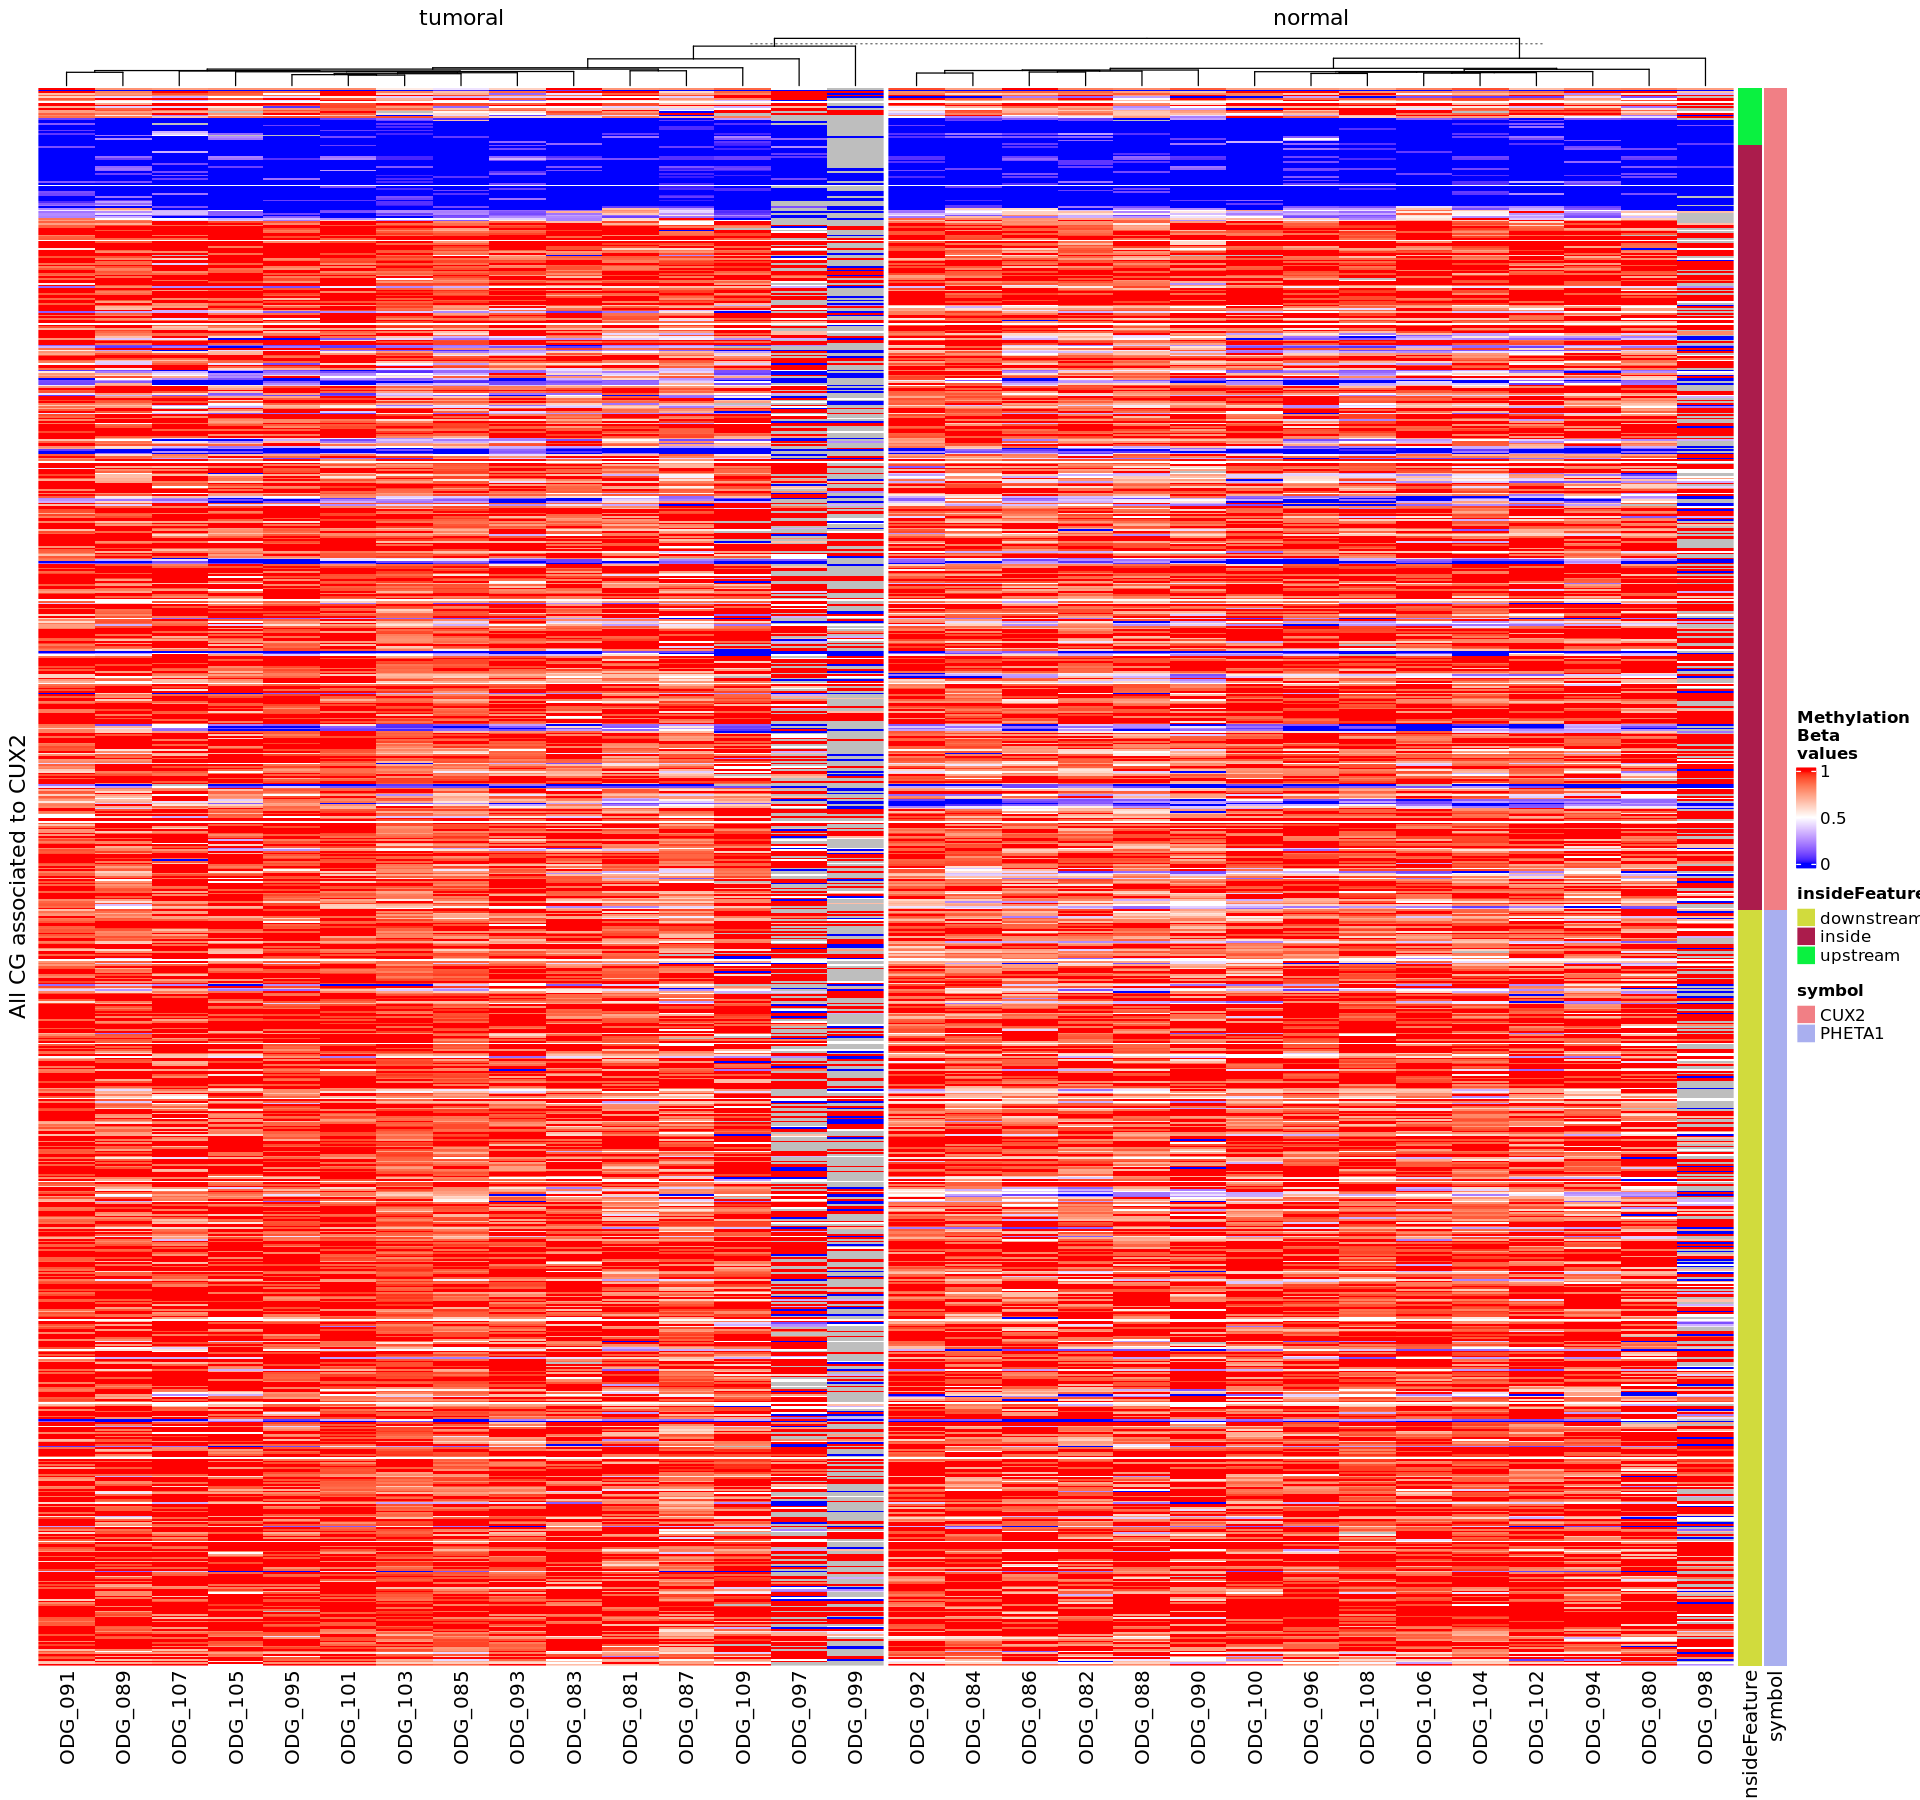

In [77]:
my_col_fun <- circlize::colorRamp2(c(0, 0.5, 1), c("blue", "white", "red"))
cols = colnames(se)

set.seed(1)
ht = Heatmap(
    dt_CUX2[, ..cols],
    col = my_col_fun,
    cluster_rows = FALSE,
    column_split = colData(se)$tissue,
    name = "Methylation\nBeta\nvalues",
    right_annotation = rowAnnotation(df = dt_CUX2[, c("insideFeature", "symbol")]),
    #"mu1", "mu2", "diff", "pval", "fdr")]),
    # right_annotation = rowAnnotation("CG relative\nto gene" = dt_CUX2$insideFeature),
    # row_labels = paste(
    #     dt_CUX2$chr,
    #     dt_CUX2$pos,
    #     sep = ":"
    # ),
    row_title = "All CG associated to CUX2",
)

set_plot_dim(16, 15)
draw(ht)

pdf("CUX2_all_CG_heatmap.pdf", width = 16, height = 15)
draw(ht)
dev.off()

### SLC22A3

Warning message:
"The input is a data frame-like object, convert it to a matrix."
`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

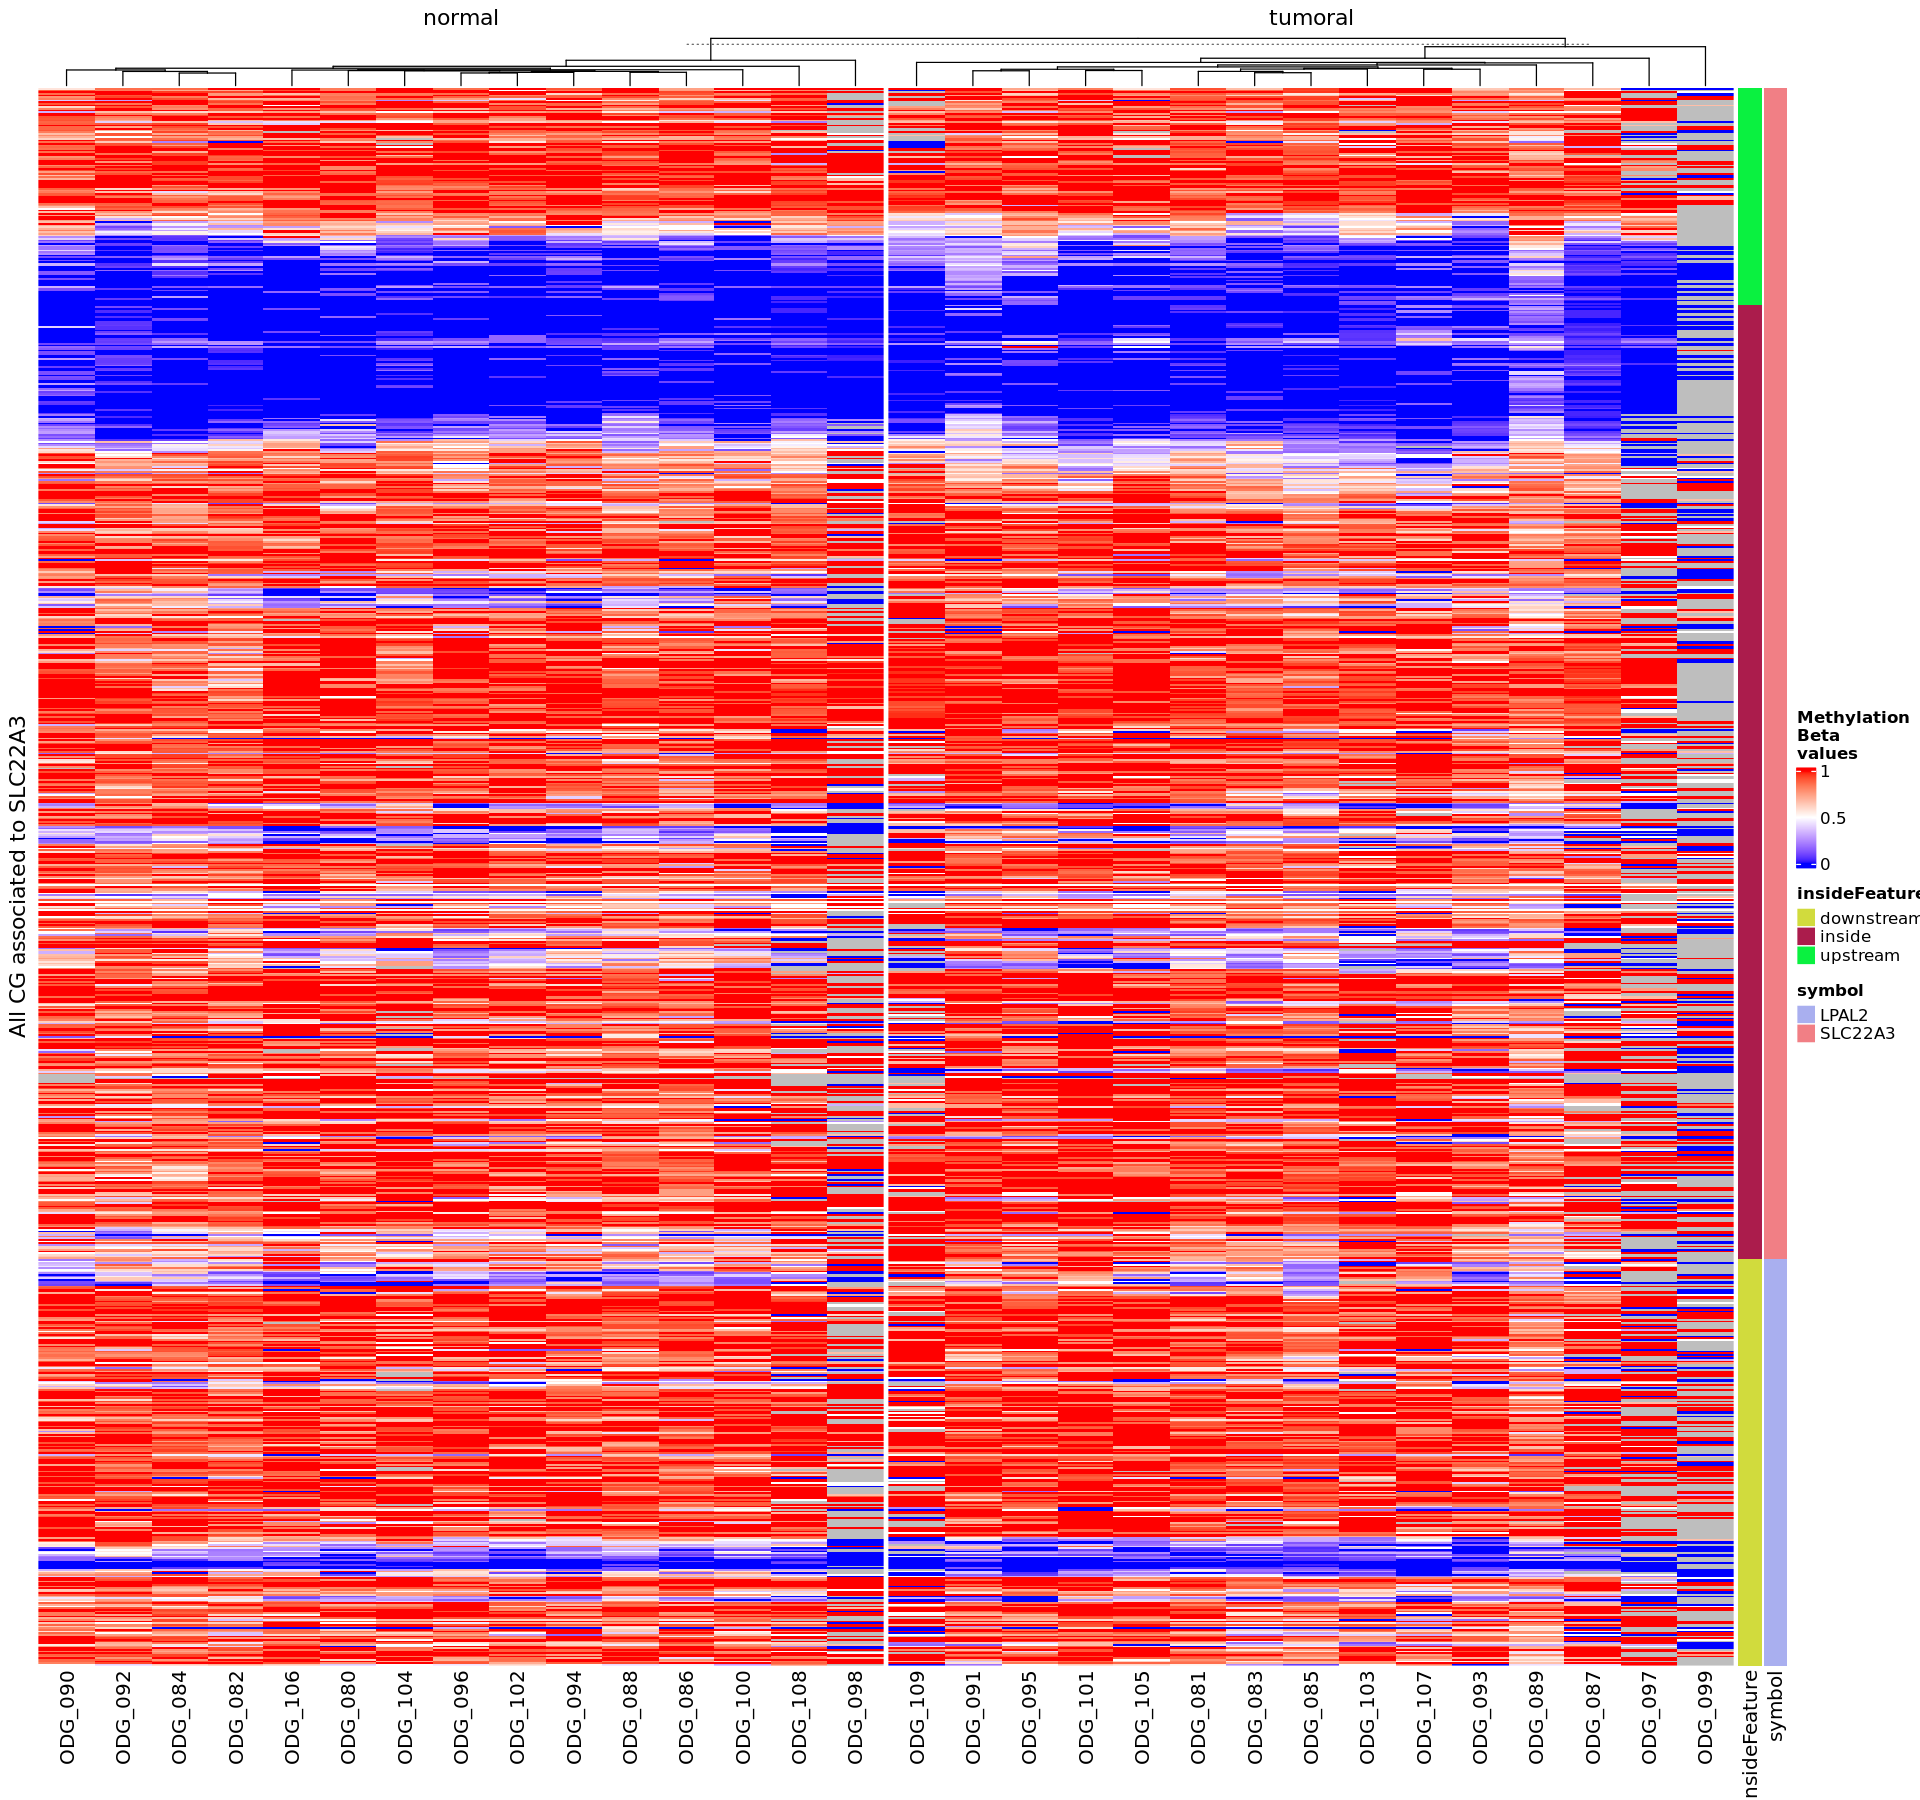

In [76]:
my_col_fun <- circlize::colorRamp2(c(0, 0.5, 1), c("blue", "white", "red"))
cols = colnames(se)

set.seed(1)
ht = Heatmap(
    dt_SLC22A3[, ..cols],
    col = my_col_fun,
    cluster_rows = FALSE,
    column_split = colData(se)$tissue,
    name = "Methylation\nBeta\nvalues",
    right_annotation = rowAnnotation(df = dt_SLC22A3[, c("insideFeature", "symbol")]),
    #"mu1", "mu2", "diff", "pval", "fdr")]),
    # right_annotation = rowAnnotation("CG relative\nto gene" = dt_SLC22A3$insideFeature),
    # row_labels = paste(
    #     dt_SLC22A3$chr,
    #     dt_SLC22A3$pos,
    #     sep = ":"
    # ),
    row_title = "All CG associated to SLC22A3",
)

set_plot_dim(16, 15)
draw(ht)

pdf("SLC22A3_all_CG_heatmap.pdf", width = 16, height = 15)
draw(ht)
dev.off()

## ANXA3

Warning message:
"The input is a data frame-like object, convert it to a matrix."


png 
  2

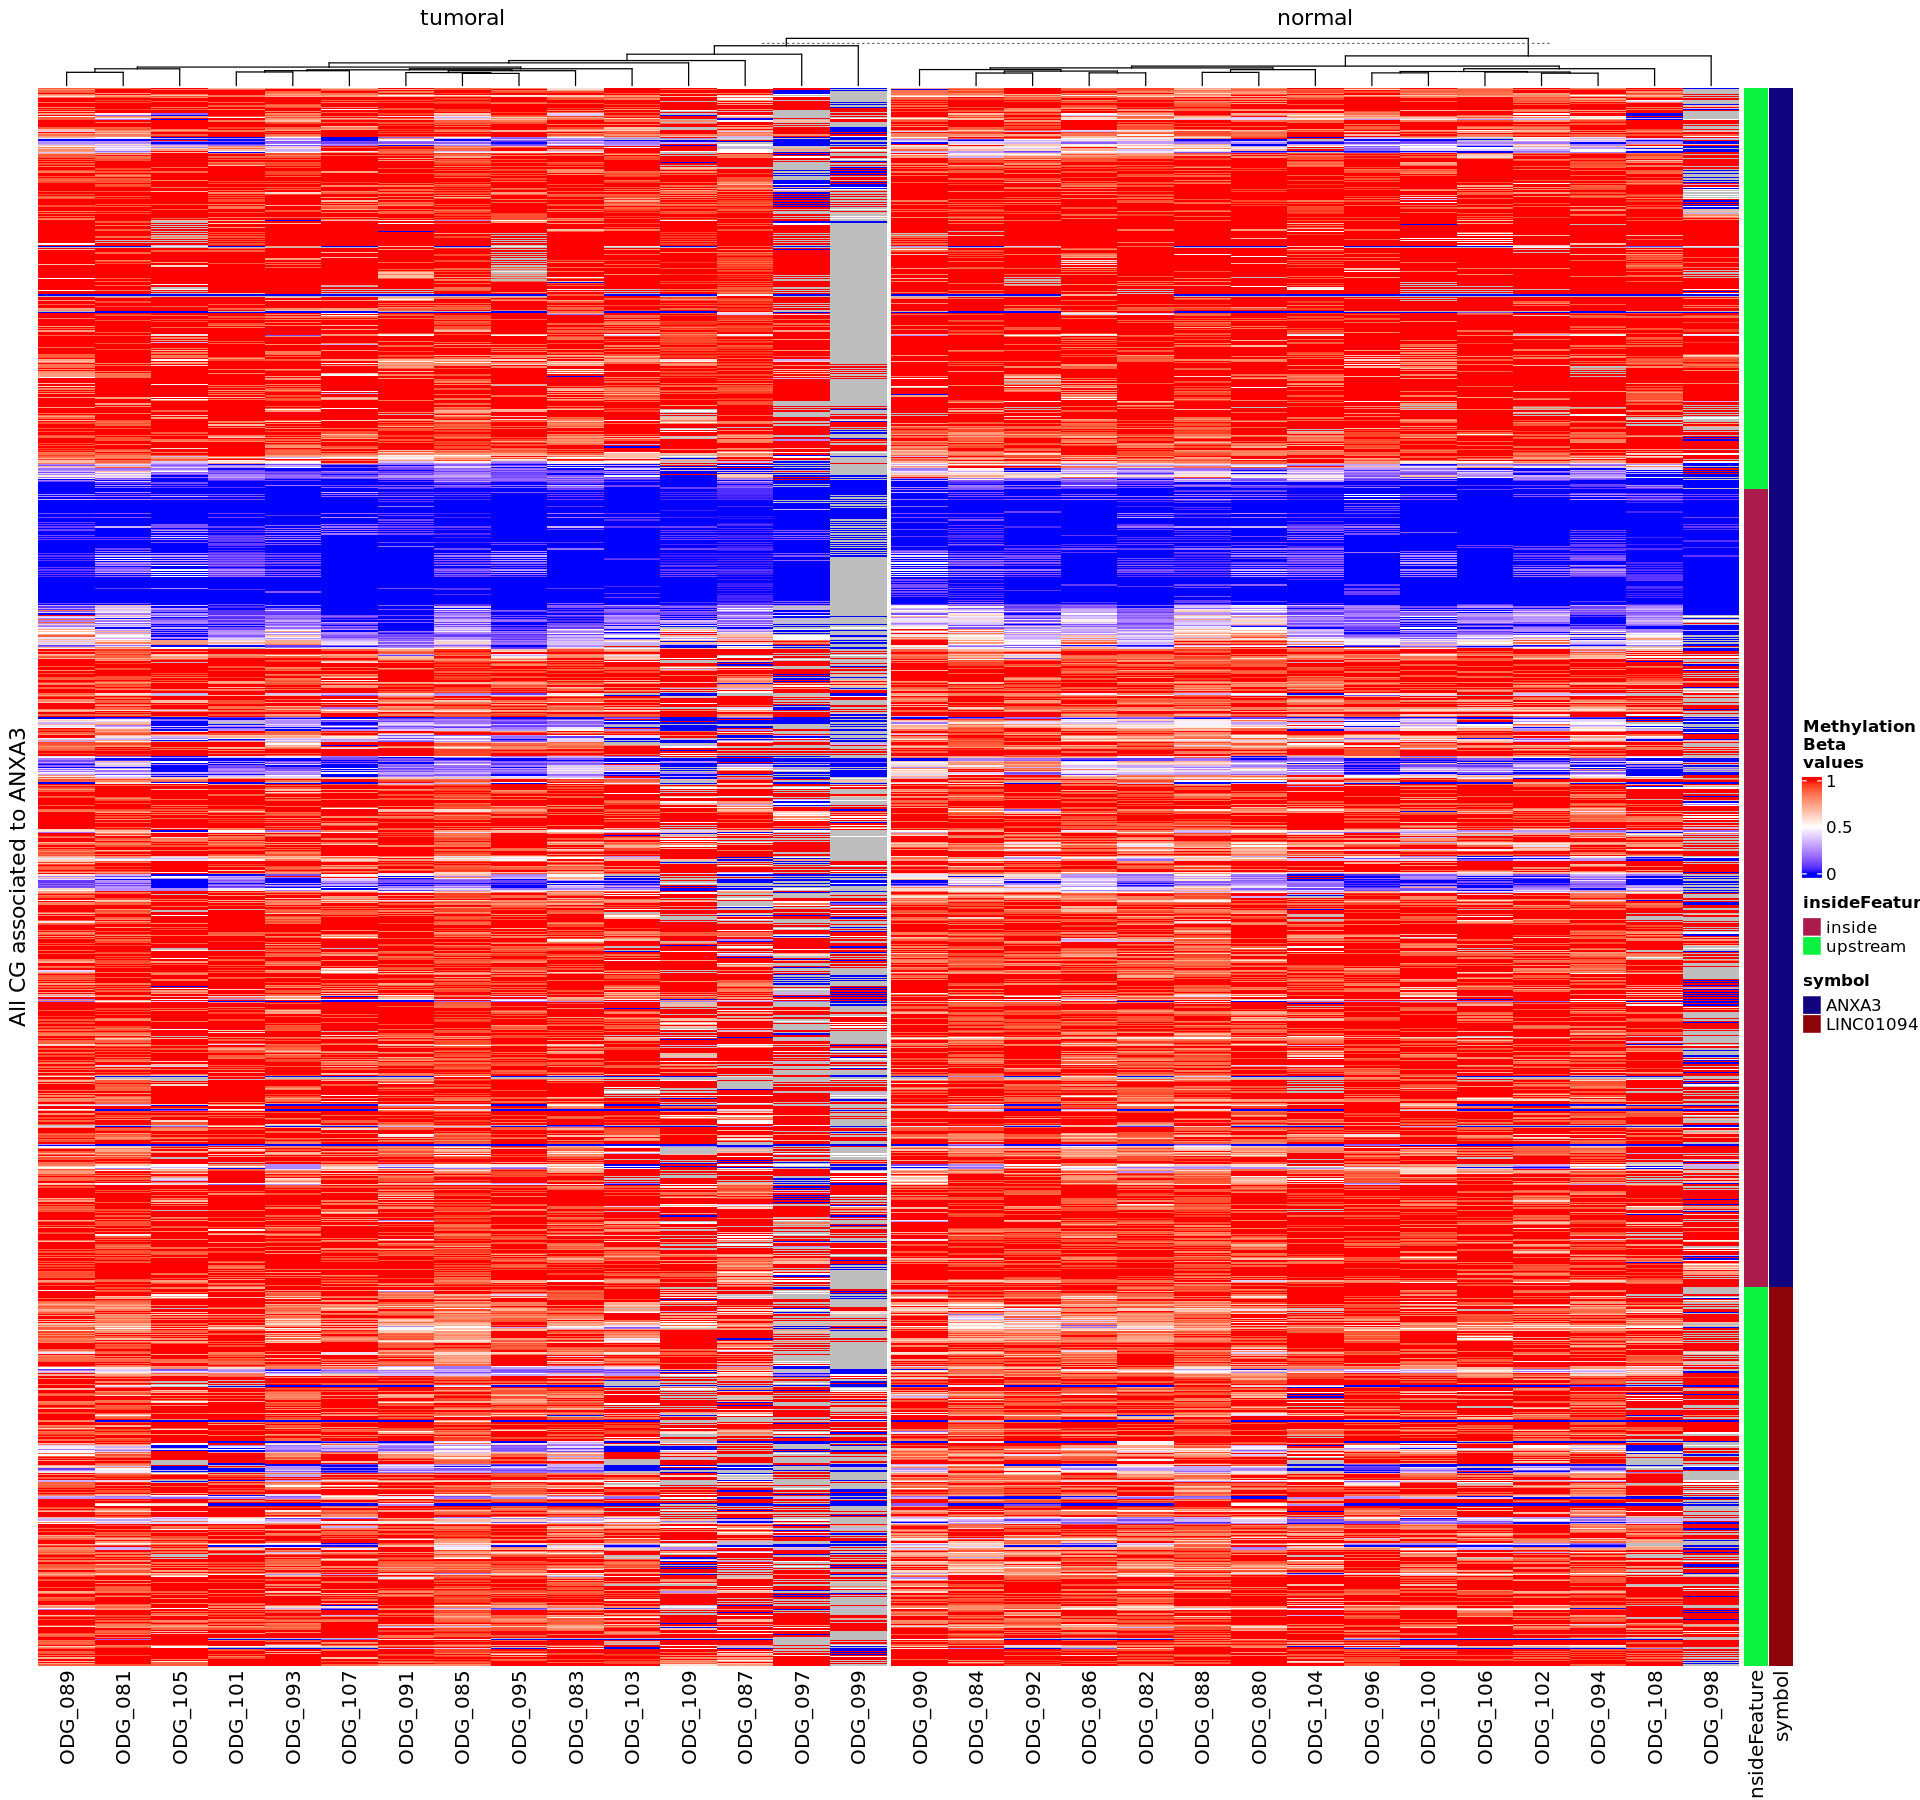

In [75]:
my_col_fun <- circlize::colorRamp2(c(0, 0.5, 1), c("blue", "white", "red"))
cols = colnames(se)

set.seed(1)
ht = Heatmap(
    dt_ANXA3[, ..cols],
    col = my_col_fun,
    cluster_rows = FALSE,
    column_split = colData(se)$tissue,
    name = "Methylation\nBeta\nvalues",
    right_annotation = rowAnnotation(df = dt_ANXA3[, c("insideFeature", "symbol")]),
    #"mu1", "mu2", "diff", "pval", "fdr")]),
    # right_annotation = rowAnnotation("CG relative\nto gene" = dt_ANXA3$insideFeature),
    # row_labels = paste(
    #     dt_ANXA3$chr,
    #     dt_ANXA3$pos,
    #     sep = ":"
    # ),
    row_title = "All CG associated to ANXA3",
)

set_plot_dim(16, 15)
draw(ht)

pdf("ANXA3_all_CG_heatmap.pdf", width = 16, height = 15)
draw(ht)
dev.off()